In [1]:
import numpy as np
import random
import math
import time
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

C:\Users\viviv\AppData\Local\Temp\ipykernel_16992\2253021780.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [3]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)


# leave-one-out evaluation: one battery is sampled randomly; the remainder are used for training.
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name]['capacity']
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v['capacity'], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re if abs(true_re - pred_re)/true_re<=1 else 1


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [4]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = 'datasets/CALCE/'
Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p,sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging when step_index == 2 or 4
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2] #konstanter Strom
            df_cv = df_lim[df_lim['Step_Index'] == 4] #konstante Spannung
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging when step_index == 7
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery[name] = df_result

Load Dataset CS2_35 ...
Load datasets/CALCE/CS2_35\CS2_35_10_15_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_22_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_29_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_01_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_08_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_24_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_06_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_13_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_20_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_10_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_18_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_24_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_28_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_2_10_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_2_4_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_17_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_18_10.xlsx .

In [6]:
print(df_result)

     cycle  capacity       SoH  resistance         CCCT         CVCT
0      1.0  1.126964  0.834239    0.102498  6585.419024  2359.168730
1      2.0  1.126642  0.834220    0.104031  6572.075291  2361.918249
2      3.0  1.126019  0.834209    0.104654  6566.714960  2362.605960
3      4.0  1.124355  0.834198    0.104031  6560.136514  2381.011933
4      5.0  1.123409  0.834189    0.101592  6612.742838  2194.316027
..     ...       ...       ...         ...          ...          ...
991  992.0  0.366656  0.137492    0.122835  1485.021686  3244.713049
992  993.0  0.366665  0.137503    0.123425  1400.679296  3255.944861
993  994.0  0.357495  0.137495    0.124349  1356.867640  3243.913667
994  995.0  0.357480  0.137490    0.123536  1327.852449  3242.275622
995  996.0  0.357501  0.137498    0.123058  1310.509117  3240.585587

[996 rows x 6 columns]


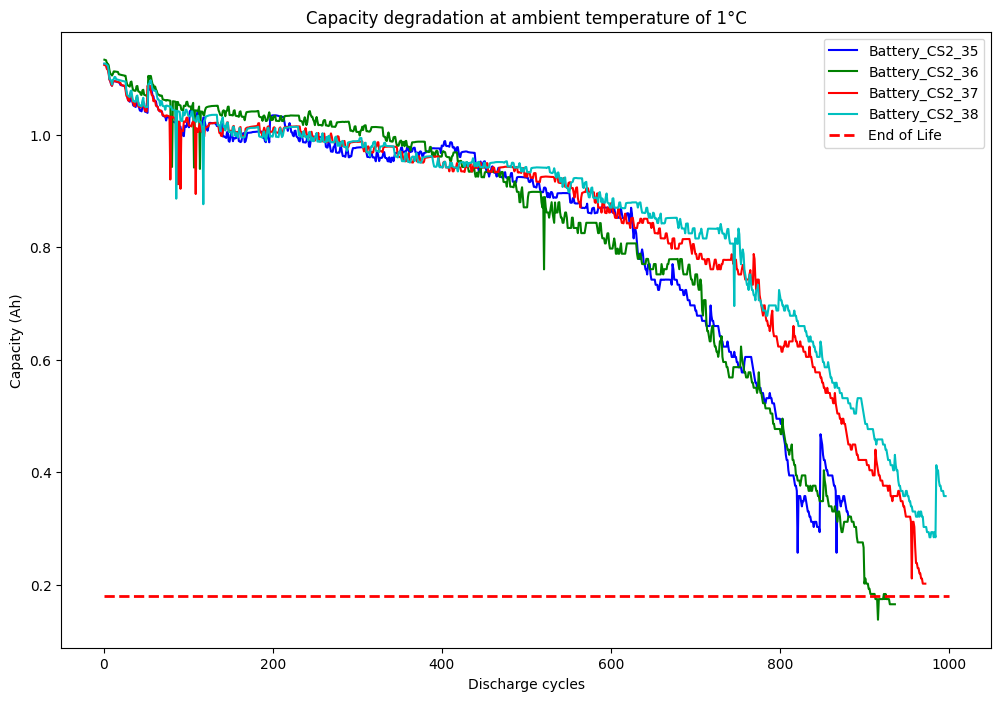

In [5]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b', 'g', 'r', 'c']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
#EOL: Battery reaches 80% of capacity
EOL = ax.hlines(y=0.18,xmin = 0, xmax = 1000, linewidth=2, color='r', linestyles = 'dashed', label='End of Life')
plt.legend()


In [7]:
def triplet_generate(data, input_size):
    features = ['capacity', 'SoH', 'resistance', 'CCCT', 'CVCT']
    triplets = []
    
    for index, row in data.iterrows():
        cycle = row['cycle']

        for feature in features:
            value = row[feature]
            mask = 1 if pd.notnull(value) else 0 # Set mask to 1 if data is present, 0 otherwise

            # Append triplet to the list
            triplets.append({
                            'Feature': feature,
                            'Cycle': cycle,
                            'Value': value,
                            'Mask': mask
            })
    return triplets

In [8]:
print(triplet_generate(df_result))

[{'Feature': 'capacity', 'Cycle': 1.0, 'Value': 1.1269639224083812, 'Mask': 1}, {'Feature': 'SoH', 'Cycle': 1.0, 'Value': 0.8342394088942104, 'Mask': 1}, {'Feature': 'resistance', 'Cycle': 1.0, 'Value': 0.1024978831410408, 'Mask': 1}, {'Feature': 'CCCT', 'Cycle': 1.0, 'Value': 6585.419023649712, 'Mask': 1}, {'Feature': 'CVCT', 'Cycle': 1.0, 'Value': 2359.1687300684016, 'Mask': 1}, {'Feature': 'capacity', 'Cycle': 2.0, 'Value': 1.1266423673534605, 'Mask': 1}, {'Feature': 'SoH', 'Cycle': 2.0, 'Value': 0.8342197865606116, 'Mask': 1}, {'Feature': 'resistance', 'Cycle': 2.0, 'Value': 0.10403060168027878, 'Mask': 1}, {'Feature': 'CCCT', 'Cycle': 2.0, 'Value': 6572.075291247802, 'Mask': 1}, {'Feature': 'CVCT', 'Cycle': 2.0, 'Value': 2361.9182494717597, 'Mask': 1}, {'Feature': 'capacity', 'Cycle': 3.0, 'Value': 1.1260185527087898, 'Mask': 1}, {'Feature': 'SoH', 'Cycle': 3.0, 'Value': 0.8342092399995156, 'Mask': 1}, {'Feature': 'resistance', 'Cycle': 3.0, 'Value': 0.10465392470359802, 'Mask': 1